In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
path = "/content"
os.chdir(path)

!ls

In [ ]:
!mkdir data
# 复制测试集
%cp -av /content/drive/MyDrive/PytorchTest/wheat-leaf-disease.rar /content/data

In [ ]:
# 解压
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/data/wheat-leaf-disease.rar').extractall('/content/data')

In [ ]:
import os
path = "/content"
os.chdir(path)

!ls

**划分数据集**

In [ ]:
import random
import shutil
from PIL import Image
import os
# 创建保存图像的文件夹
def makedir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
random.seed(1) # 随机种子

# 1.确定原图像数据集路径
dataset_dir = "/content/data/wheat-leaf-disease"  ##原始数据集路径
# 2.确定数据集划分后保存的路径
split_dir = "/content/data/wheat-leaf-disease/after"  ##划分后保存路径
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")
# 3.确定将数据集划分为训练集，验证集，测试集的比例
train_pct = 0.6
valid_pct = 0.2
test_pct = 0.2
# 4.划分
for root, dirs, files in os.walk(dataset_dir):
    for sub_dir in dirs: # 遍历0，1，2，3，4，5...9文件夹
        imgs = os.listdir(os.path.join(root, sub_dir)) # 展示目标文件夹下所有的文件名
        imgs = list(filter(lambda x: x.endswith('.jpg'), imgs)) # 取到所有以.jpg结尾的文件
        random.shuffle(imgs)  # 乱序图片路径
        img_count = len(imgs)  # 计算图片数量
        train_point = int(img_count * train_pct)
        valid_point = int(img_count * (train_pct + valid_pct))

        for i in range(img_count):
            if i < train_point:  # 保存0-train_point的图片到训练集
                out_dir = os.path.join(train_dir, sub_dir)
            elif i < valid_point:  # 保存train_point-valid_point的图片到验证集
                out_dir = os.path.join(valid_dir, sub_dir)
            else:  #  保存valid_point-结束的图片到测试集
                out_dir = os.path.join(test_dir, sub_dir)
            makedir(out_dir) # 创建文件夹
            target_path = os.path.join(out_dir, imgs[i]) # 指定目标保存路径
            src_path = os.path.join(dataset_dir, sub_dir, imgs[i])  #指定目标原图像路径
            shutil.copy(src_path, target_path)  # 复制图片

        print('Class:{}, train:{}, valid:{}, test:{}'.format(sub_dir, train_point, valid_point-train_point,
                                                             img_count-valid_point))


**导包**

In [ ]:
import os
import time
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

**制作数据集**

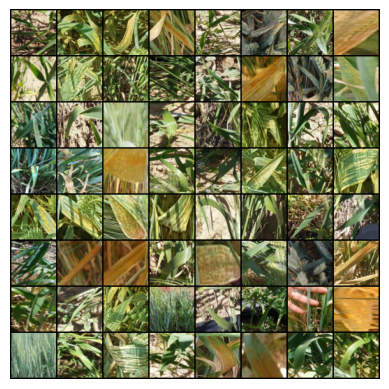

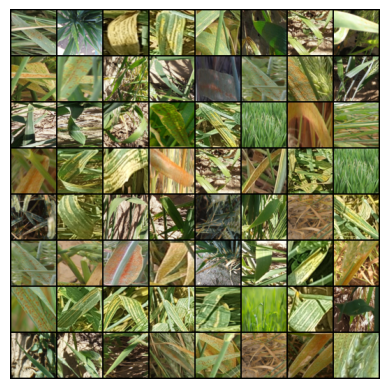

In [ ]:
class_labels = ('Brown_rust', 'Healthy', 'Septoria', 'Yellow_rust')


# 定义数据转换
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# 生成索引
def make_txt(root, file_name, label):
    global f
    path = os.path.join(root, file_name)

    data = os.listdir(path)
    if 'train' in root:
        f = open(root + '/' + 'train_data.txt', 'a')

    if 'val' in root:
        f = open(root + '/' + 'val_data.txt', 'a')

    for line in data:
        f.write(line + ' ' + str(label) + ' ' + file_name + '\n')
    f.close()


train_path = r'./data/wheat-leaf-disease/after/train'
val_path = r'./data/wheat-leaf-disease/after/val'
for index, value in enumerate(class_labels):
    make_txt(train_path, file_name=value, label=index)
    make_txt(val_path, file_name=value, label=index)


# 读取训练集索引构成DataSet
class WheatLeafBaseDataset(Dataset):
    def __init__(self, img_path, split, transform=None):
        super(WheatLeafBaseDataset, self).__init__()
        self.root = img_path
        self.split = split
        self.txt_root = os.path.join(self.root, self.split, f'{self.split}_data.txt')
        f = open(self.txt_root, 'r')
        data = f.readlines()
        imgs = []
        labels = []
        for line in data:
            line = line.rstrip()
            word = line.split()
            imgs.append(os.path.join(self.root, self.split, word[2], word[0]))
            labels.append(word[1])
        self.img = imgs
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        img = self.img[item]
        label = self.label[item]
        img = Image.open(img).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = np.array(label).astype(np.int64)
        label = torch.from_numpy(label)
        return img, label


class WheatLeafTrainDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafTrainDataset, self).__init__(img_path, 'train', transform)


class WheatLeafValDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafValDataset, self).__init__(img_path, 'val', transform)


path = r'./data/wheat-leaf-disease/after'

train_dataset = WheatLeafTrainDataset(path, transform=transforms)
val_dataset = WheatLeafValDataset(path, transform=transforms)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, num_workers=2)


def ShowImage(data_loader):
    for i, data in enumerate(data_loader):
        images, labels = data

        # 打印数据集中的图片
        img = torchvision.utils.make_grid(images).numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.axis("off")
        plt.show()

        break


ShowImage(train_data_loader)
ShowImage(val_data_loader)

In [ ]:
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_list = []
acc_list = []

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # 卷积部分
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接部分
        self.classifier = nn.Sequential(
            nn.Linear(16 * 13 * 13, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平卷积层输出
        x = self.classifier(x)
        return x



# 数据预处理
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 随机大小裁剪和缩放
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 标准化
])


# 创建模型实例和定义损失函数、优化器
model = nn.vgg11()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = next(net.parameters()).device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().cpu().item()
            net.train()
            n += y.shape[0]
    return acc_sum / n


def train(net, train_iter, test_iter, optimizer, device, num_epochs):
    sum_time = 0.0

    net = net.to(device)
    print("training on", device)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            l = loss_fn(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1

        test_acc = evaluate_accuracy(test_iter, net)

        print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, (train_acc_sum / n) * 100, test_acc * 100, time.time() - start))
        loss_list.append((train_l_sum / batch_count))
        acc_list.append(test_acc)
        sum_time += (time.time() - start)
        torch.save(net.state_dict(), f'/content/drive/MyDrive/PytorchTest/LeNet-wheatleafdiesas_model.pth')
        # 降低梯度
        scheduler.step(test_acc)

        # 保存 loss_list 到文件
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_loss.txt', 'w') as file:
        for loss in loss_list:
            file.write(str(loss) + '\n')

        # 保存 acc_list 到文件
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_accuracy.txt', 'w') as file:
        for acc in acc_list:
            file.write(str(acc) + '\n')
    with open('/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/CNN_times.txt', 'w') as file:
        file.write(str(sum_time))


lr, num_epochs = 0.001, 50
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=0.00001)
train(model, train_data_loader, val_data_loader, optimizer, device, num_epochs)

print('Training and testing completed')

In [ ]:
import matplotlib.pyplot as plt

print(loss_list)
print(acc_list)

plt.figure(figsize=(12, 6))  # 创建一个大图形

# 子图1：损失曲线
plt.subplot(121)
plt.plot(loss_list)
plt.title('VGG11 Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 子图2：准确率曲线
plt.subplot(122)
plt.plot(acc_list, color='green')
plt.title('VGG11 Test-acc curves')
plt.xlabel('Epochs')
plt.ylabel('acc')

# 保存整个图形为一张图片
plt.savefig('/content/drive/MyDrive/PytorchTest/ResultImg/VGG11.jpg')

plt.show()

用PlantVillage-Dataset做预训练

In [ ]:
git clone https://github.com/spMohanty/PlantVillage-Dataset